
# PCA Mini-Project 
### Faces recognition example using eigenfaces and SVMs
Our discussion of PCA spent a lot of time on theoretical issues, so in this mini-project we’ll ask you to play around with some sklearn code. The eigenfaces code is interesting and rich enough to serve as the testbed for this entire mini-project.



Note:
The dataset used in this example is a preprocessed excerpt of the
"[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)", aka [LFW_ Download](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (233MB). [Original source](http://scikit-learn.org/0.15/auto_examples/applications/face_recognition.html).

In [2]:

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## Loading the dataset

In [3]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people('data', min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)


# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print( "n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### Split into a training and testing set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Compute PCA

We can now compute a [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) (eigenfaces) on the face dataset (treated as unlabeled dataset): unsupervised feature extraction / dimensionality reduction.

In [64]:
# [10, 15, 25, 50, 100, 250]

n_components = 600

print( "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]) )
t0 = time()

# TODO: Create an instance of PCA, initializing with n_components=n_components and whiten=True
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

#TODO: pass the training dataset (X_train) to pca's 'fit()' method
pca = pca.fit(X_train)


print("done in %0.3fs" % (time() - t0))

Extracting the top 600 eigenfaces from 966 faces
done in 1.067s


Projecting the input data on the eigenfaces orthonormal basis

In [65]:
eigenfaces = pca.components_.reshape((n_components, h, w))

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


done in 0.075s


## Train a SVM classification model

Let's fit a [SVM classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to the training set. We'll use [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find a good set of parameters for the classifier.

In [66]:
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("\ndone in %0.fs" % (time() - t0))

Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

done in 135s


## Evaluation of the model quality on the test set

#### 1. Classification Report
Now that we have the classifier trained, let's run it on the test dataset and qualitatively evaluate its results. Sklearn's [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) shows some of the main classification metrics for each class.

In [67]:
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.55      0.85      0.67        13
     Colin Powell       0.64      0.90      0.75        60
  Donald Rumsfeld       0.58      0.70      0.63        27
    George W Bush       0.93      0.73      0.82       146
Gerhard Schroeder       0.61      0.56      0.58        25
      Hugo Chavez       0.60      0.60      0.60        15
       Tony Blair       0.72      0.64      0.68        36

      avg / total       0.77      0.74      0.74       322



#### 2. Confusion Matrix

Another way to look at the performance of the classifier is by looking the [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). We can do that by simply invoking [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):

Normalized confusion matrix
[[ 0.15384615  0.46153846  0.07692308  0.23076923  0.07692308  0.          0.        ]
 [ 0.13333333  0.53333333  0.03333333  0.16666667  0.06666667  0.01666667
   0.05      ]
 [ 0.07407407  0.33333333  0.33333333  0.18518519  0.03703704  0.
   0.03703704]
 [ 0.04794521  0.14383562  0.06849315  0.57534247  0.09589041  0.02054795
   0.04794521]
 [ 0.          0.04        0.16        0.4         0.2         0.08        0.12      ]
 [ 0.06666667  0.13333333  0.13333333  0.53333333  0.          0.13333333
   0.        ]
 [ 0.02777778  0.08333333  0.16666667  0.19444444  0.13888889  0.
   0.38888889]]


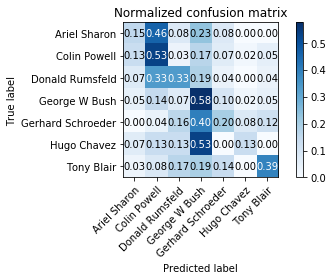

In [61]:
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = target_names
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

#### 3. Plotting The Most Significant Eigenfaces

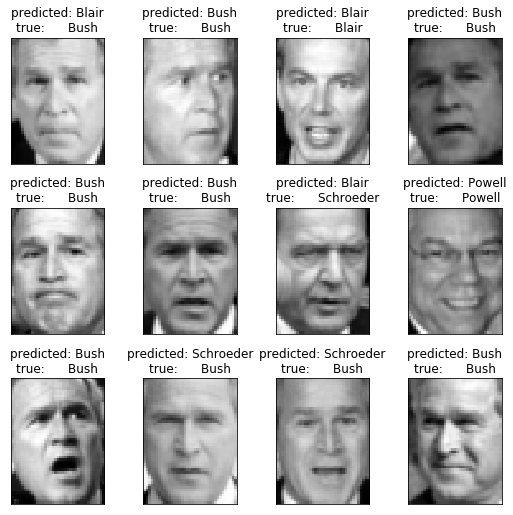

In [62]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())



# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

pl.show()

IndexError: index 10 is out of bounds for axis 0 with size 10

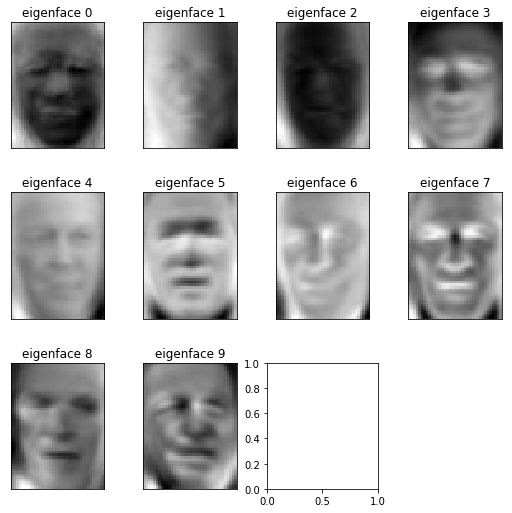

In [63]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

## Quiz: Explained Variance Of Each PC

We mentioned that PCA will order the principal components, with the first PC giving the direction of maximal variance, second PC has second-largest variance, and so on. How much of the variance is explained by the first principal component? The second?

In [29]:
# Percentage of variance explained by each of the selected components
print(pca.explained_variance_ratio_[0:2])

[ 0.19346534  0.1511682 ]


## Quiz: How Many PCs To Use?

Now you'll experiment with keeping different numbers of principal components. In a multiclass classification problem like this one (more than 2 labels to apply), accuracy is a less-intuitive metric than in the 2-class case. Instead, a popular metric is the F1 score.

We’ll learn about the F1 score properly in the lesson on evaluation metrics, but you’ll figure out for yourself whether a good classifier is characterized by a high or low F1 score. You’ll do this by varying the number of principal components and watching how the F1 score changes in response.

As you add more principal components as features for training your classifier, do you expect it to get better or worse performance?

I believe the more principal components, the better the performance will be. However, as the number of PC components increases, the computational cost will also increase.

## Quiz: F1 Score Vs. No. Of PCs Used

Change n_components to the following values: [10, 15, 25, 50, 100, 250]. For each number of principal components, note the F1 score for Ariel Sharon. (For 10 PCs, the plotting functions in the code will break, but you should be able to see the F1 scores.) If you see a higher F1 score, does it mean the classifier is doing better, or worse?

The lowest F1 score was when the PCs were 10. Which means that was the worst performance.
The highest F1 score was for 100 pcs, which was 0.87, so far the best performance achieved.


PCs - F1 - Traintime

10    -    0.47      - 49s

15    -    0.63      - 18s

25    -    0.75      - 10s

50    -    0.83      - 11s

100   -    0.87      - 21s

250   -    0.84      - 55s

600   -    0.74      - 135s

## Quiz: Dimensionality Reduction And Overfitting
Do you see any evidence of overfitting when using a large number of PCs? Does the dimensionality reduction of PCA seem to be helping your performance here?

Considering the experiment performed above, where the number of PCs varied from 0 to 600, the performance achieved its peak when it was used 100 PCs. Afer that, the F1 scored only decreased. This could explain that when there are too many PCs, the system overfits and start to miss when tested with the validation set. 

In other words, increasing too much the number of PCs may infer in a overfitted model. 